# Time Series Analysis & Training Dataset

In [7]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Enable python to import modules from parent directory
import sys
sys.path.append("..")

from src.config import *

# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None

## Read and standardize the base data

We are using the "Poblacion_Subordinada_Nivel_Ingresos.csv" dataset. 

In [10]:
# Read data and rename columns
data_path = os.path.join(DATA_RAW_PATH, "Poblacion_Subordinada_Nivel_Ingresos.csv")
data = pd.read_csv(data_path, encoding='latin1').rename(
    columns = {
        "Periodo": "t",
        "Entidad_Federativa": "state",
        "Sexo": "gender",
        "Grupo_edad": "age",
        "Nivel_ingreso": "wage_level",
        "Numero_personas": "population"
    }
)

# Standardize state variable
standardize_state = {
    'Coahuila': 'Coahuila de Zaragoza',
    'Ciudad de M\x82xico': 'Distrito Federal',
    'Estado de M\x82xico': 'México', 
    'Michoac\xa0n': 'Michoacán de Ocampo', 
    'Nuevo Le¢n': 'Nuevo León',
    'Queretaro': 'Querétaro', 
    'San Luis Potos¡': 'San Luis Potosí', 
    'Veracruz': 'Veracruz de Ignacio de la Llave',
    'Yucat\xa0n': 'Yucatán'
}

data['state'] = [standardize_state.get(s, s) for s in data.state]

# Standardize year variable
data['year'] = [int(str(y)[:4]) for y in data.t]

# Standardize age variable
standardize_age_dictionary = {age_val: age_val.replace("A¥OS", "").replace(" ", "") for age_val in data.age.unique()} 
data['age'] = [standardize_age_dictionary[age] for age in data.age]
data = data.query("age != 'NOESPECIFICADO'")

# Filter out the 'Nacional' datapoints
data = data[data['state'] != 'Nacional']

# Filter out 'No especificado' age level
data = data.query("wage_level != 'No especificado'")

# Show resulting data
print(data.shape)
data.head()

(99421, 7)


,t,state,gender,age,wage_level,population,year
0,20050301,Aguascalientes,Hombre,15A24,Menos de 1 s.m.,4284,2005
1,20050301,Aguascalientes,Hombre,15A24,1 salario m¡nimo,179,2005
2,20050301,Aguascalientes,Hombre,15A24,M s de 2 hasta 3 s.m.,10503,2005
3,20050301,Aguascalientes,Hombre,15A24,M s de 3 hasta 5 s.m.,16803,2005
4,20050301,Aguascalientes,Hombre,15A24,M s de 5 hasta 10 s.m.,1955,2005


## Read and standardize the wage data



In [12]:
wage_path = os.path.join(DATA_RAW_PATH, "wages.csv")
wage = pd.read_csv(wage_path).rename(
    columns = {
        "Salarios Minimos": "state",
        "Zona": "zone"
    }
)

wage_year_columns = [c for c in wage.columns if c.startswith("2")]

print(wage.shape)
wage.head()

(32, 17)


,state,zone,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aguascalientes,C,44.05,45.81,47.60,49.50,51.95,54.47,56.70,59.08,61.38,63.77,70.1,73.04,80.04,88.36,102.68
1,Baja California,Frontera,46.80,48.67,50.57,52.59,54.80,55.84,59.82,62.33,64.76,67.29,70.1,73.04,80.04,88.36,176.72
2,Baja California Sur,A,46.80,48.67,50.57,52.59,54.80,57.46,59.82,62.33,64.76,67.29,70.1,73.04,80.04,88.36,102.68
3,Campeche,C,44.05,45.81,47.60,49.50,51.95,54.47,56.70,59.08,61.38,63.77,70.1,73.04,80.04,88.36,102.68
4,Coahuila de Zaragoza,C,44.05,45.81,47.60,49.50,51.95,54.47,56.70,59.08,61.38,63.77,70.1,73.04,80.04,88.36,102.68


Create a dataset with the following columns: state, year, minimum_wage

In [13]:
min_wage = wage.drop("zone", 1).melt(
    id_vars=["state"], 
    value_vars=wage_year_columns, 
    var_name="year", 
    value_name="minimum_wage")

min_wage

,state,year,minimum_wage
0,Aguascalientes,2005,44.05
1,Baja California,2005,46.80
2,Baja California Sur,2005,46.80
3,Campeche,2005,44.05
4,Coahuila de Zaragoza,2005,44.05
...,...,...,...
475,Tamaulipas,2019,102.68
476,Tlaxcala,2019,102.68
477,Veracruz de Ignacio de la Llave,2019,102.68
478,Yucatán,2019,102.68


## Calculate the numeric wage!

The difference of the unique "state" values in both the base-data and the wage dataset should be zero. 

In [14]:
# Create a set of the wage dataset: 
min_wage_state_set = {e for e in min_wage.state.unique()}
len(min_wage_state_set)

32

In [15]:
# Create a set of the base-data: 
data_state_set = {e for e in data.state.unique()} 
len(data_state_set)

32

In [16]:
# Calculate the difference 

assert(not len(data_state_set - min_wage_state_set))
assert(not len(min_wage_state_set - data_state_set ))

Create an "idx" column by combining the "year" and "state" cols:

In [17]:
data.loc[:, 'idx'] = data.apply(lambda row: str(row["year"]) + row["state"] , 1)
data.head()

,t,state,gender,age,wage_level,population,year,idx
0,20050301,Aguascalientes,Hombre,15A24,Menos de 1 s.m.,4284,2005,2005Aguascalientes
1,20050301,Aguascalientes,Hombre,15A24,1 salario m¡nimo,179,2005,2005Aguascalientes
2,20050301,Aguascalientes,Hombre,15A24,M s de 2 hasta 3 s.m.,10503,2005,2005Aguascalientes
3,20050301,Aguascalientes,Hombre,15A24,M s de 3 hasta 5 s.m.,16803,2005,2005Aguascalientes
4,20050301,Aguascalientes,Hombre,15A24,M s de 5 hasta 10 s.m.,1955,2005,2005Aguascalientes


In [18]:
min_wage['idx'] = min_wage.apply(lambda row: str(row["year"]) + row["state"] , 1)
min_wage.head()

,state,year,minimum_wage,idx
0,Aguascalientes,2005,44.05,2005Aguascalientes
1,Baja California,2005,46.80,2005Baja California
2,Baja California Sur,2005,46.80,2005Baja California Sur
3,Campeche,2005,44.05,2005Campeche
4,Coahuila de Zaragoza,2005,44.05,2005Coahuila de Zaragoza


Join and update the base data: 

In [19]:
data_cols = ["t", "state", "gender", "age", "population", "wage_level", "minimum_wage"]
data = data.set_index("idx").join(min_wage.set_index("idx"), lsuffix='_data', rsuffix='_wage')\
    .reset_index(drop=True).rename(columns={"state_data": "state"})[data_cols]
data

,t,state,gender,age,population,wage_level,minimum_wage
0,20050301,Aguascalientes,Hombre,15A24,4284,Menos de 1 s.m.,44.05
1,20050301,Aguascalientes,Hombre,15A24,179,1 salario m¡nimo,44.05
2,20050301,Aguascalientes,Hombre,15A24,10503,M s de 2 hasta 3 s.m.,44.05
3,20050301,Aguascalientes,Hombre,15A24,16803,M s de 3 hasta 5 s.m.,44.05
4,20050301,Aguascalientes,Hombre,15A24,1955,M s de 5 hasta 10 s.m.,44.05
...,...,...,...,...,...,...,...
99416,20190601,Zacatecas,Mujer,45A64,22803,M s de 10 s.m.,102.68
99417,20190601,Zacatecas,Mujer,45A64,136,No recibe ingresos,102.68
99418,20190601,Zacatecas,Mujer,65YMAS,1521,Menos de 1 s.m.,102.68
99419,20190601,Zacatecas,Mujer,65YMAS,1281,M s de 3 hasta 5 s.m.,102.68


Show the wage levels and assign a numeric value: 

In [20]:
data.wage_level.unique()

array(['Menos de 1 s.m.', '1 salario m¡nimo', 'M\xa0s de 2 hasta 3 s.m.',
       'M\xa0s de 3 hasta 5 s.m.', 'M\xa0s de 5 hasta 10 s.m.',
       'M\xa0s de 10 s.m.', 'No recibe ingresos',
       'M\xa0s de 1 hasta 2 s.m.'], dtype=object)

In [21]:
wage_factor = {
    'Menos de 1 s.m.': 0.5,
    '1 salario m¡nimo': 1,
    'M\xa0s de 1 hasta 2 s.m.': 1.5,
    'M\xa0s de 2 hasta 3 s.m.': 2.5,
    'M\xa0s de 3 hasta 5 s.m.': 4,
    'M\xa0s de 5 hasta 10 s.m.': 7.5,
    'M\xa0s de 10 s.m.': 11,
    'No recibe ingresos': 0,
}

Calculate the wage_factor and the resulting numeric wage: 

In [22]:
data["wage_factor"] = [wage_factor[v] for v in data.wage_level]
data["wage"] = data.apply(lambda row: row['wage_factor'] * row["minimum_wage"], 1)
data = data[["t", "state", "gender", "age", "population", "wage"]]

data.head()

,t,state,gender,age,population,wage
0,20050301,Aguascalientes,Hombre,15A24,4284,22.025
1,20050301,Aguascalientes,Hombre,15A24,179,44.050
2,20050301,Aguascalientes,Hombre,15A24,10503,110.125
3,20050301,Aguascalientes,Hombre,15A24,16803,176.200
4,20050301,Aguascalientes,Hombre,15A24,1955,330.375


Now we need to create an weighted average for each group:

In [23]:
# Calculate the total population per group (t, state, gender, age)

population_agg = data.groupby(["t", "state", "gender", "age"]).population.sum().reset_index()\
    .rename(columns={"population": "population_total"})

# Create an index
population_agg["idx"] = population_agg.apply(
    lambda row: str(row["t"]) + row["state"] + row["gender"] + row["age"], 1).values

# Select relevant columns
population_agg = population_agg[["idx", "population_total"]]

population_agg.head()

,idx,population_total
0,20050301AguascalientesHombre15A24,43610
1,20050301AguascalientesHombre25A44,86369
2,20050301AguascalientesHombre45A64,37632
3,20050301AguascalientesHombre65YMAS,6100
4,20050301AguascalientesMujer15A24,20895


In [24]:
# Calculate an index for each group(t, state, gender, age)
data['idx'] = data.apply(
    lambda row: str(row["t"]) + row["state"] + row["gender"] + row["age"], 1).values

data

,t,state,gender,age,population,wage,idx
0,20050301,Aguascalientes,Hombre,15A24,4284,22.025,20050301AguascalientesHombre15A24
1,20050301,Aguascalientes,Hombre,15A24,179,44.050,20050301AguascalientesHombre15A24
2,20050301,Aguascalientes,Hombre,15A24,10503,110.125,20050301AguascalientesHombre15A24
3,20050301,Aguascalientes,Hombre,15A24,16803,176.200,20050301AguascalientesHombre15A24
4,20050301,Aguascalientes,Hombre,15A24,1955,330.375,20050301AguascalientesHombre15A24
...,...,...,...,...,...,...,...
99416,20190601,Zacatecas,Mujer,45A64,22803,1129.480,20190601ZacatecasMujer45A64
99417,20190601,Zacatecas,Mujer,45A64,136,0.000,20190601ZacatecasMujer45A64
99418,20190601,Zacatecas,Mujer,65YMAS,1521,51.340,20190601ZacatecasMujer65YMAS
99419,20190601,Zacatecas,Mujer,65YMAS,1281,410.720,20190601ZacatecasMujer65YMAS


In [25]:
# Join the base data with the population total
data = data.set_index("idx").join(population_agg.set_index('idx'), how="left").reset_index(drop=True)
data.head()

,t,state,gender,age,population,wage,population_total
0,20050301,Aguascalientes,Hombre,15A24,4284,22.025,43610
1,20050301,Aguascalientes,Hombre,15A24,179,44.050,43610
2,20050301,Aguascalientes,Hombre,15A24,10503,110.125,43610
3,20050301,Aguascalientes,Hombre,15A24,16803,176.200,43610
4,20050301,Aguascalientes,Hombre,15A24,1955,330.375,43610


In [26]:
# Calculate the population weight factor 
data['population_weight'] = data['population'] / data['population_total']
data.head()

,t,state,gender,age,population,wage,population_total,population_weight
0,20050301,Aguascalientes,Hombre,15A24,4284,22.025,43610,0.098234
1,20050301,Aguascalientes,Hombre,15A24,179,44.050,43610,0.004105
2,20050301,Aguascalientes,Hombre,15A24,10503,110.125,43610,0.240839
3,20050301,Aguascalientes,Hombre,15A24,16803,176.200,43610,0.385302
4,20050301,Aguascalientes,Hombre,15A24,1955,330.375,43610,0.044829


In [27]:
# Calculate the partial wage
data["wage_partial"] = data['population_weight'] * data['wage']
data

,t,state,gender,age,population,wage,population_total,population_weight,wage_partial
0,20050301,Aguascalientes,Hombre,15A24,4284,22.025,43610,0.098234,2.163612
1,20050301,Aguascalientes,Hombre,15A24,179,44.050,43610,0.004105,0.180806
2,20050301,Aguascalientes,Hombre,15A24,10503,110.125,43610,0.240839,26.522423
3,20050301,Aguascalientes,Hombre,15A24,16803,176.200,43610,0.385302,67.890131
4,20050301,Aguascalientes,Hombre,15A24,1955,330.375,43610,0.044829,14.810436
...,...,...,...,...,...,...,...,...,...
99416,20190601,Zacatecas,Mujer,45A64,22803,1129.480,36226,0.629465,710.968157
99417,20190601,Zacatecas,Mujer,45A64,136,0.000,36226,0.003754,0.000000
99418,20190601,Zacatecas,Mujer,65YMAS,1521,51.340,8882,0.171245,8.791729
99419,20190601,Zacatecas,Mujer,65YMAS,1281,410.720,8882,0.144224,59.235794


In [28]:
# Verify weigths
data.groupby(['t', 'state', 'gender', 'age']).population_weight.sum().reset_index()\
    .query("population_weight < 0.999 or population_weight > 1.001")\
    .shape

(0, 5)

In [29]:
# Calculate weighted wage: 
data = data.groupby(['t', 'state', 'gender', 'age']).wage_partial.sum().reset_index().rename(columns={"wage_partial": "wage"})
data

,t,state,gender,age,wage
0,20050301,Aguascalientes,Hombre,15A24,204.544119
1,20050301,Aguascalientes,Hombre,25A44,179.162457
2,20050301,Aguascalientes,Hombre,45A64,177.004165
3,20050301,Aguascalientes,Hombre,65YMAS,197.470373
4,20050301,Aguascalientes,Mujer,15A24,285.416383
...,...,...,...,...,...
14843,20190601,Zacatecas,Hombre,65YMAS,240.096922
14844,20190601,Zacatecas,Mujer,15A24,749.794483
14845,20190601,Zacatecas,Mujer,25A44,757.093879
14846,20190601,Zacatecas,Mujer,45A64,820.100733


## Create useful time column

In [30]:
data["t"] = [int(str(year)[:4]) + (int(str(year)[4:6]) / 12) - 0.25 for year in data.t]
data

,t,state,gender,age,wage
0,2005.00,Aguascalientes,Hombre,15A24,204.544119
1,2005.00,Aguascalientes,Hombre,25A44,179.162457
2,2005.00,Aguascalientes,Hombre,45A64,177.004165
3,2005.00,Aguascalientes,Hombre,65YMAS,197.470373
4,2005.00,Aguascalientes,Mujer,15A24,285.416383
...,...,...,...,...,...
14843,2019.25,Zacatecas,Hombre,65YMAS,240.096922
14844,2019.25,Zacatecas,Mujer,15A24,749.794483
14845,2019.25,Zacatecas,Mujer,25A44,757.093879
14846,2019.25,Zacatecas,Mujer,45A64,820.100733


## Subset and plot functions!

In [31]:
# Filter out 2019 (note: let's reconsider this!)
data = data.query("t < 2019")

In [32]:
# Show unique values per variable

print("Gender:", *["\t - " + value for value in data.gender.unique()], sep='\n')
print("Age:", *["\t - " + value for value in data.age.unique()], sep='\n')
print("State:", *["\t - " + value for value in data.state.unique()], sep='\n')

Gender:
	 - Hombre
	 - Mujer
Age:
	 - 15A24
	 - 25A44
	 - 45A64
	 - 65YMAS
State:
	 - Aguascalientes
	 - Baja California
	 - Baja California Sur
	 - Campeche
	 - Chiapas
	 - Chihuahua
	 - Coahuila de Zaragoza
	 - Colima
	 - Distrito Federal
	 - Durango
	 - Guanajuato
	 - Guerrero
	 - Hidalgo
	 - Jalisco
	 - Michoacán de Ocampo
	 - Morelos
	 - México
	 - Nayarit
	 - Nuevo León
	 - Oaxaca
	 - Puebla
	 - Querétaro
	 - Quintana Roo
	 - San Luis Potosí
	 - Sinaloa
	 - Sonora
	 - Tabasco
	 - Tamaulipas
	 - Tlaxcala
	 - Veracruz de Ignacio de la Llave
	 - Yucatán
	 - Zacatecas


In [33]:
# Print total combinations

print("Expected number of groups:", len(data.gender.unique()) * len(data.age.unique()) * len(data.state.unique()))

Expected number of groups: 256


In [34]:
# Create subset / plot functions
import random

def get_subset(df, state, gender, age):
    return df.query(f"state == '{state}' & gender == '{gender}' & age == '{age}'")

def plot(df, state, gender, age, x="t", y="wage"):
    sub_df = get_subset(df, state, gender, age)
    y_values = sub_df[y].values
    increments = y_values[1:] / y_values[:-1] - 1  
    sub_df.plot.scatter(x=x, y=y)
    plt.title("Wage level for {} between {} from {}".format(gender, age, state))
    plt.xlabel("Year")
    plt.ylabel("Wage")
    plt.show()
    plt.plot(sub_df[x][1:].values, increments)
    plt.title("Increments (%) for {} between {} from {}".format(gender, age, state))
    plt.xlabel("Year")
    plt.ylabel("%")
    plt.show()
    

def get_random_group(df):
    return {
        "state": random.choice(df.state.unique()),
        "age": random.choice(df.age.unique()),
        "gender": random.choice(df.gender.unique())
    }

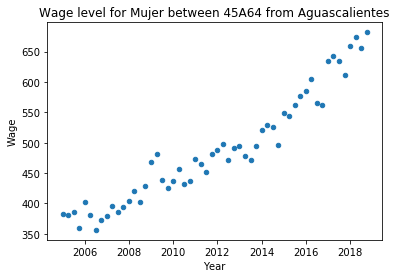

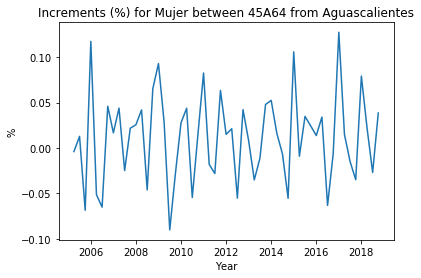

,t,state,gender,age,wage
6,2005.00,Aguascalientes,Mujer,45A64,382.773801
262,2005.25,Aguascalientes,Mujer,45A64,381.252663
518,2005.50,Aguascalientes,Mujer,45A64,386.129621
774,2005.75,Aguascalientes,Mujer,45A64,359.659292
1030,2006.00,Aguascalientes,Mujer,45A64,401.856441


In [35]:
# TEST COMBINATION: 
# - Aguascalientes
# - Mujer
# - 45A64
args = [data, "Aguascalientes", "Mujer", "45A64"]
plot(*args)
get_subset(*args).head()

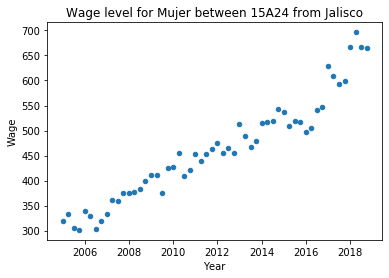

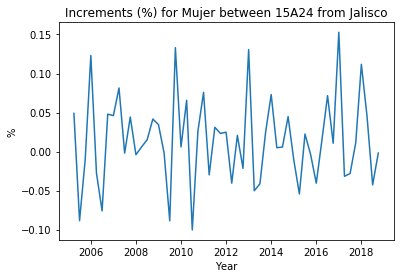

,t,state,gender,age,wage
108,2005.00,Jalisco,Mujer,15A24,318.625664
364,2005.25,Jalisco,Mujer,15A24,334.204189
620,2005.50,Jalisco,Mujer,15A24,304.626555
876,2005.75,Jalisco,Mujer,15A24,301.431669
1132,2006.00,Jalisco,Mujer,15A24,338.521096


In [36]:
# TEST COMBINATION: 
# - Jalisco
# - Mujer
# - 15A24
args = [data, "Jalisco", "Mujer", "15A24"]
plot(*args)
get_subset(*args).head()

{'state': 'Durango', 'age': '45A64', 'gender': 'Mujer'}


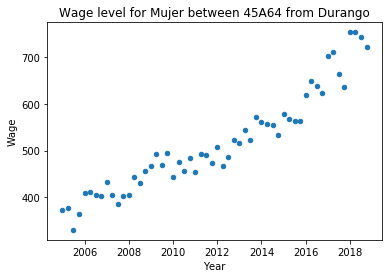

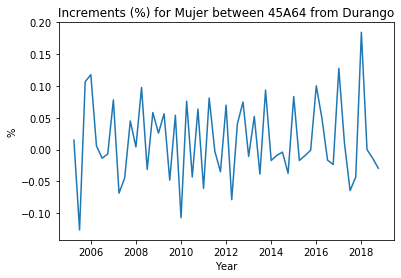

,t,state,gender,age,wage
78,2005.00,Durango,Mujer,45A64,371.819568
334,2005.25,Durango,Mujer,45A64,377.322239
590,2005.50,Durango,Mujer,45A64,329.679661
846,2005.75,Durango,Mujer,45A64,364.903504
1102,2006.00,Durango,Mujer,45A64,407.896184


In [37]:
# TEST RANDOM COMBINATION: 
group_config = get_random_group(data)
print(group_config)
plot(data, **group_config)
get_subset(data, **group_config).head()

## Partial Autocorrelation

In [38]:
def get_relevant_lags(data, state, gender, age, threshold=0.25, max_lags=10, max_lag_position=None, plot_flag=False):
    sub_df = get_subset(data, state, gender, age).sort_values(["t"], ascending=True)
    if not max_lag_position:
        # We don't want to lose more than 20% of our data! 
        max_lag_position = len(sub_df) / 5
    # Discuss why should we forecast the time-series increments vs the absolute values 
    vector = sub_df.wage.values[1:] / sub_df.wage.values[:-1] - 1  
    pacf_vector = pacf(vector)
    if plot_flag:
        plot_acf(vector, lags=max_lags)
        plot_pacf(vector, lags=max_lags)
    return [i for i, val in enumerate(pacf_vector) 
            if (val < -threshold or val > threshold) and i > 0 and i < max_lag_position][:max_lags]

In [40]:
# Example: 
get_relevant_lags(data, **group_config)

[1, 2, 3, 6, 7]

In [41]:
# Create all possible combinations!

groups = [
    {
        "gender":gender, 
        "state": state, 
        "age": age
    } 
      for gender in data.gender.unique() 
      for state in data.state.unique() 
      for age in data.age.unique()
]

len(groups)

256

In [42]:
# Get the relevenat lags for each group

relevant_lags = []
for group in groups: 
    try: 
        lags = get_relevant_lags(data, **group)
        relevant_lags.append( {
        "group": group,
        "lags": lags
        })
    except Exception as e:
        print("Skipping group {} due to error: {}".format(str(group), str(e)))
        
len(relevant_lags)

256

In [43]:
relevant_lags_data = [{"lag": lag, "group_index": i} for i, elm in enumerate(relevant_lags) for lag in elm["lags"]]
len(relevant_lags_data)

838

In [44]:
df_lags = pd.DataFrame(relevant_lags_data).groupby("lag").size().reset_index().rename(columns={0: "count"})
df_lags.head()

,lag,count
0,1,176
1,2,156
2,3,131
3,4,38
4,5,31


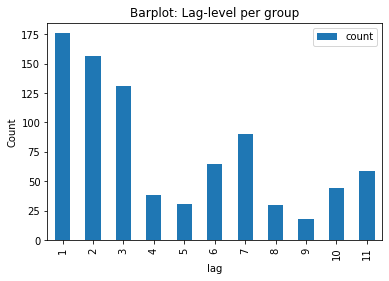

In [45]:
df_lags.plot.bar(x="lag", y="count")
plt.title("Barplot: Lag-level per group")
plt.ylabel("Count")
plt.show()

In [46]:
threshold = 50
candidate_lags = list(df_lags.query("count > {}".format(threshold)).lag.values)
print("Lag-level present in at least {} groups:".format(threshold), candidate_lags)

Lag-level present in at least 50 groups: [1, 2, 3, 6, 7, 11]


## Wage increments

In [47]:
# Calculate an index for each group(t, state, gender, age)
data['idx'] = data.apply(
    lambda row: str(row["t"]) + row["state"] + row["gender"] + row["age"], 1).values

data

,t,state,gender,age,wage,idx
0,2005.00,Aguascalientes,Hombre,15A24,204.544119,2005.0AguascalientesHombre15A24
1,2005.00,Aguascalientes,Hombre,25A44,179.162457,2005.0AguascalientesHombre25A44
2,2005.00,Aguascalientes,Hombre,45A64,177.004165,2005.0AguascalientesHombre45A64
3,2005.00,Aguascalientes,Hombre,65YMAS,197.470373,2005.0AguascalientesHombre65YMAS
4,2005.00,Aguascalientes,Mujer,15A24,285.416383,2005.0AguascalientesMujer15A24
...,...,...,...,...,...,...
14331,2018.75,Zacatecas,Hombre,65YMAS,181.756169,2018.75ZacatecasHombre65YMAS
14332,2018.75,Zacatecas,Mujer,15A24,608.675418,2018.75ZacatecasMujer15A24
14333,2018.75,Zacatecas,Mujer,25A44,623.514884,2018.75ZacatecasMujer25A44
14334,2018.75,Zacatecas,Mujer,45A64,582.554903,2018.75ZacatecasMujer45A64


In [48]:
def get_increments(df, state, gender, age):
    sub_df = get_subset(df, state, gender, age).sort_values(["t"], ascending=True)
    vector = sub_df.wage.values[1:] / sub_df.wage.values[:-1] - 1  
    return pd.DataFrame({"wage_increase": vector, "idx": sub_df.idx.values[1:]})

In [49]:
df_delta = pd.DataFrame()
for group in groups:
    iter_delta = get_increments(data, **group)
    df_delta = df_delta.append(iter_delta)
    
df_delta.shape

(14080, 2)

In [50]:
assert(len(df_delta) == len(data) - len(groups)) 

In [51]:
cols = ["t", "state", "gender", "age", "wage", "wage_increase"]
data = df_delta.set_index("idx").join(data.set_index("idx")).reset_index(drop=True)[cols]
data.head()

,t,state,gender,age,wage,wage_increase
0,2005.25,Aguascalientes,Hombre,15A24,209.490175,0.024181
1,2005.50,Aguascalientes,Hombre,15A24,209.828509,0.001615
2,2005.75,Aguascalientes,Hombre,15A24,210.432990,0.002881
3,2006.00,Aguascalientes,Hombre,15A24,230.011866,0.093041
4,2006.25,Aguascalientes,Hombre,15A24,217.629019,-0.053836


## Add lags

In [52]:
# Calculate an index for each group(t, state, gender, age)
data['idx'] = data.apply(
    lambda row: str(row["t"]) + row["state"] + row["gender"] + row["age"], 1).values

data

,t,state,gender,age,wage,wage_increase,idx
0,2005.25,Aguascalientes,Hombre,15A24,209.490175,0.024181,2005.25AguascalientesHombre15A24
1,2005.50,Aguascalientes,Hombre,15A24,209.828509,0.001615,2005.5AguascalientesHombre15A24
2,2005.75,Aguascalientes,Hombre,15A24,210.432990,0.002881,2005.75AguascalientesHombre15A24
3,2006.00,Aguascalientes,Hombre,15A24,230.011866,0.093041,2006.0AguascalientesHombre15A24
4,2006.25,Aguascalientes,Hombre,15A24,217.629019,-0.053836,2006.25AguascalientesHombre15A24
...,...,...,...,...,...,...,...
14075,2017.75,Zacatecas,Mujer,65YMAS,585.796198,0.041502,2017.75ZacatecasMujer65YMAS
14076,2018.00,Zacatecas,Mujer,65YMAS,636.471242,0.086506,2018.0ZacatecasMujer65YMAS
14077,2018.25,Zacatecas,Mujer,65YMAS,571.261064,-0.102456,2018.25ZacatecasMujer65YMAS
14078,2018.50,Zacatecas,Mujer,65YMAS,638.754094,0.118147,2018.5ZacatecasMujer65YMAS


In [53]:
def add_lag(df, state, gender, age, lag=1, target="wage_increase"):
    sub_df = get_subset(df, state, gender, age).sort_values(["t"], ascending=True)
    vector = sub_df[target].values
    actual = vector[lag:]
    lag_values = vector[:-lag]
    return pd.DataFrame({"lag_{}".format(lag): lag_values, "value":  actual, "idx": sub_df.idx.values[lag:]})

def add_lags(df, state, gender, age, lags=[], target="wage_increase", _result=pd.DataFrame()):
    if not lags:
        return _result
    if not len(_result):
        _result = add_lag(df, state, gender, age, lags[0], target)
        return add_lags(df, state, gender, age, lags[1:], target, _result)
    temp = add_lag(df, state, gender, age, lags[0], target)
    _result = temp.set_index("idx").join(_result.set_index("idx"), lsuffix="_dup").drop("value_dup", 1).reset_index()
    return add_lags(df, state, gender, age, lags[1:], target, _result)
    

In [54]:
data_lags = pd.DataFrame()
for group in groups:
    temp = add_lags(data, lags=candidate_lags, **group)
    data_lags = data_lags.append(temp)
    
print(data_lags.shape)
data_lags.head()

(11264, 8)


,idx,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,value
0,2008.0AguascalientesHombre15A24,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,0.075232
1,2008.25AguascalientesHombre15A24,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,-0.021322
2,2008.5AguascalientesHombre15A24,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,-0.023162
3,2008.75AguascalientesHombre15A24,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,-0.028393
4,2009.0AguascalientesHombre15A24,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,0.028896


In [55]:
# Verify that the number of rows in data_lags makes sense. 

assert(len(data) - len(groups) * max(candidate_lags) == len(data_lags))

In [56]:
# Join back with original dataset

data = data_lags.set_index('idx').join(data.set_index('idx')).reset_index(drop=True)
data.head()

,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,value,t,state,gender,age,wage,wage_increase
0,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,0.075232,2008.00,Aguascalientes,Hombre,15A24,241.908258,0.075232
1,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,-0.021322,2008.25,Aguascalientes,Hombre,15A24,236.750270,-0.021322
2,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,-0.023162,2008.50,Aguascalientes,Hombre,15A24,231.266706,-0.023162
3,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,-0.028393,2008.75,Aguascalientes,Hombre,15A24,224.700408,-0.028393
4,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,0.028896,2009.00,Aguascalientes,Hombre,15A24,231.193457,0.028896


In [57]:
# Verify that value == wage_increase

assert(len(data.query("value != wage_increase")) == 0)

In [58]:
data = data.drop(["value", "wage"], 1)
data.head() 

,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,t,state,gender,age,wage_increase
0,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,2008.00,Aguascalientes,Hombre,15A24,0.075232
1,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,2008.25,Aguascalientes,Hombre,15A24,-0.021322
2,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,2008.50,Aguascalientes,Hombre,15A24,-0.023162
3,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,2008.75,Aguascalientes,Hombre,15A24,-0.028393
4,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,2009.00,Aguascalientes,Hombre,15A24,0.028896


## Add population data

TODO. 

In [ ]:
# Create an index using: t, state, gender, age

In [169]:
# Create the same index for the population dataset

In [170]:
# Join both dataframes into a single one and drop useless columns

In [59]:
data.head()

,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,t,state,gender,age,wage_increase
0,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,2008.00,Aguascalientes,Hombre,15A24,0.075232
1,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,2008.25,Aguascalientes,Hombre,15A24,-0.021322
2,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,2008.50,Aguascalientes,Hombre,15A24,-0.023162
3,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,2008.75,Aguascalientes,Hombre,15A24,-0.028393
4,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,2009.00,Aguascalientes,Hombre,15A24,0.028896


In [60]:
save_clean_data_path = os.path.join(DATA_CLEAN_PATH, 'data.csv')
data.to_csv(save_clean_data_path, index=False)

## Training dataset!

In [61]:
# Select relevant columns (drop "t" and other irrelevant cols)
data = data.drop("t", 1)

data.head()

,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,state,gender,age,wage_increase
0,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,Aguascalientes,Hombre,15A24,0.075232
1,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,Aguascalientes,Hombre,15A24,-0.021322
2,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,Aguascalientes,Hombre,15A24,-0.023162
3,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,Aguascalientes,Hombre,15A24,-0.028393
4,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,Aguascalientes,Hombre,15A24,0.028896


{'Hombre': 0.01908992515852309, 'Mujer': 0.0177358650046141}

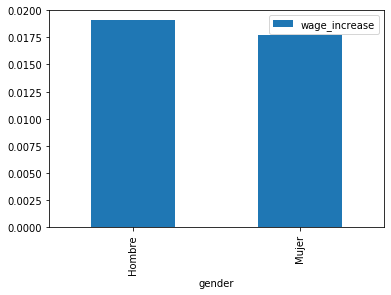

In [62]:
# Gender

gender_agg = data.groupby("gender").wage_increase.mean()

gender_agg.reset_index().plot.bar(x='gender', y='wage_increase')
gender_transform = gender_agg.to_dict()
gender_transform

In [63]:
data['gender'] = data['gender'].replace(gender_transform).values
data.head()

,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,state,gender,age,wage_increase
0,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,Aguascalientes,0.01909,15A24,0.075232
1,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,Aguascalientes,0.01909,15A24,-0.021322
2,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,Aguascalientes,0.01909,15A24,-0.023162
3,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,Aguascalientes,0.01909,15A24,-0.028393
4,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,Aguascalientes,0.01909,15A24,0.028896


{'15A24': 0.016815840014873122,
 '25A44': 0.014806661268644154,
 '45A64': 0.01586244486652458,
 '65YMAS': 0.02616663417623265}

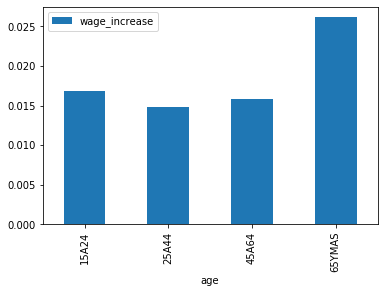

In [64]:
# Age

age_agg = data.groupby("age").wage_increase.mean()

age_agg.reset_index().plot.bar(x='age', y='wage_increase')
age_transform = age_agg.to_dict()
age_transform

In [65]:
data['age'] = data['age'].replace(age_transform).values
data.head()

,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,state,gender,age,wage_increase
0,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,Aguascalientes,0.01909,0.016816,0.075232
1,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,Aguascalientes,0.01909,0.016816,-0.021322
2,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,Aguascalientes,0.01909,0.016816,-0.023162
3,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,Aguascalientes,0.01909,0.016816,-0.028393
4,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,Aguascalientes,0.01909,0.016816,0.028896


{'Aguascalientes': 0.015672318967502194,
 'Baja California': 0.015447397965925515,
 'Baja California Sur': 0.02278842229039663,
 'Campeche': 0.017547066215075225,
 'Chiapas': 0.019915314162418905,
 'Chihuahua': 0.015562726517175808,
 'Coahuila de Zaragoza': 0.016281222914472527,
 'Colima': 0.016724145382626888,
 'Distrito Federal': 0.014590591694587122,
 'Durango': 0.020239758359340068,
 'Guanajuato': 0.01689595536880139,
 'Guerrero': 0.02351966245513488,
 'Hidalgo': 0.02583814886640127,
 'Jalisco': 0.01573773974425543,
 'Michoacán de Ocampo': 0.01861332501742892,
 'Morelos': 0.01741936081239764,
 'México': 0.016807752670560783,
 'Nayarit': 0.015783169295204343,
 'Nuevo León': 0.013988898602345045,
 'Oaxaca': 0.020220888257431572,
 'Puebla': 0.020282622887929657,
 'Querétaro': 0.020440608570669216,
 'Quintana Roo': 0.0189358422209701,
 'San Luis Potosí': 0.018542684338245758,
 'Sinaloa': 0.018799178997424178,
 'Sonora': 0.016767016532992732,
 'Tabasco': 0.021115270473239463,
 'Tamaulip

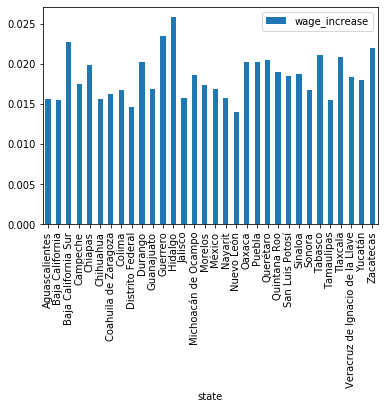

In [66]:
# State
state_agg = data.groupby("state").wage_increase.mean()

state_agg.reset_index().plot.bar(x='state', y='wage_increase')
state_transform = state_agg.to_dict()
state_transform

In [67]:
data['state'] = data['state'].replace(state_transform).values
data.head()

,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,state,gender,age,wage_increase
0,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,0.015672,0.01909,0.016816,0.075232
1,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,0.015672,0.01909,0.016816,-0.021322
2,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,0.015672,0.01909,0.016816,-0.023162
3,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,0.015672,0.01909,0.016816,-0.028393
4,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,0.015672,0.01909,0.016816,0.028896


## Save training data

In [68]:
data.head()

,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,state,gender,age,wage_increase
0,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,0.015672,0.01909,0.016816,0.075232
1,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,0.015672,0.01909,0.016816,-0.021322
2,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,0.015672,0.01909,0.016816,-0.023162
3,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,0.015672,0.01909,0.016816,-0.028393
4,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,0.015672,0.01909,0.016816,0.028896


In [69]:
curated_data_path = os.path.join(DATA_CLEAN_PATH, "ml-curated-data.csv")
data.to_csv(curated_data_path, index=False)

## Quick linear test

In [61]:
from sklearn.linear_model import LinearRegression

target_col = "wage_increase"
features = [c for c in data.columns if c != target_col]

train = data.sample(frac=0.7)
test = data.drop(train.index)

In [62]:
train_x = train.drop(target_col, 1)
train_y = train.drop(features, 1)

test_x = test.drop(target_col, 1)
test_y = test.drop(features, 1)

In [63]:
reg = LinearRegression().fit(train_x, train_y)

In [64]:
estimates = reg.predict(train_x)
error = np.asmatrix(train_y.values - estimates)
sme = (error.T * error / len(error)).tolist()[0][0]
sme

0.006749839431748588

In [65]:
np.sqrt(sme)

0.08215740643270446

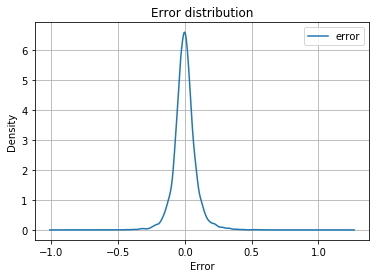

,error
count,7.885000e+05
mean,1.813529e-15
std,8.216262e+00
min,-4.416152e+01
25%,-4.257962e+00
50%,-2.534552e-01
75%,3.852101e+00
max,6.978792e+01


In [66]:
df_errors = pd.DataFrame({'error': [e for ls in error.tolist() for e in ls]})
df_errors.plot.kde()
plt.title("Error distribution")
plt.xlabel("Error")
plt.grid()
plt.show()

100 * df_errors.describe()

In [67]:
test_results = pd.DataFrame(
    {
        "y": train_y.wage_increase.values,
        "y_estimate": [e for ls in estimates.tolist() for e in ls]
    }
)

100 * test_results.describe()

,y,y_estimate
count,788500.000000,788500.000000
mean,1.786050,1.786050
std,9.617891,4.999686
min,-48.133108,-29.889012
25%,-3.397294,-0.803709
50%,0.990970,1.667357
75%,6.055713,4.353749
max,72.686528,30.506361


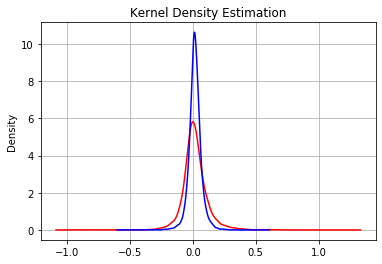

In [68]:
test_results.y.plot.kde(c='r')
test_results.y_estimate.plot.kde(c='b')
plt.title("Kernel Density Estimation")
plt.grid()
plt.show()

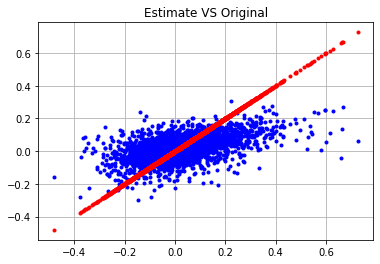

In [69]:
plt.plot(test_results.y, test_results.y_estimate, '.b')
plt.plot(test_results.y, test_results.y, '.r')
plt.title("Estimate VS Original")
plt.grid()
plt.show()